# Concepts attribution for fCRP-EfficientNet

In [1]:
!nvidia-smi

Tue Jun  3 17:48:43 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     On   | 00000000:82:00.0 Off |                  N/A |
| 23%   28C    P8     9W / 250W |      4MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
import data_loader.data_loaders as module_data
import model.model as module_arch
from parse_config import ConfigParser
from utils import read_json

import math
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.spatial import distance

In [4]:
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept

from crp.image import imgify

# 1. Base

In [5]:
json = read_json('config_prostate.json')
model_chkpt = 'saved/models/fCRP-prostate/0602_213033/model_best.pth'

In [6]:
config = ConfigParser(json, resume=model_chkpt)

In [7]:
checkpoint = torch.load(config.resume, weights_only = False)
state_dict = checkpoint['state_dict']

In [8]:
model = config.init_obj('arch', module_arch)

model.load_state_dict(state_dict)
model.eval()

data_loader = config.init_obj('data_loader_test', module_data)
sample_subset = [data_loader.dataset[i] for i in {0, 20, 40, 50}]

In [9]:
sample_subset[0][0].shape

torch.Size([3, 374, 374])

In [10]:
sample, idx = sample_subset[0]

In [11]:
model(sample.unsqueeze(0)).argmax()

tensor(0)

In [12]:
def generate_results(model):
	model.eval()
	for (input, label) in sample_subset:
		output = model(input.unsqueeze(0))
		pred_class = output.argmax()
		print(f"Model prediction {pred_class}. GT-Label: {label}")
	model.train()

generate_results(model)

Model prediction 0. GT-Label: 0
Model prediction 2. GT-Label: 2
Model prediction 1. GT-Label: 1
Model prediction 2. GT-Label: 2


In [13]:
from crp.helper import get_layer_names

conditions = [{"y": 46}]
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

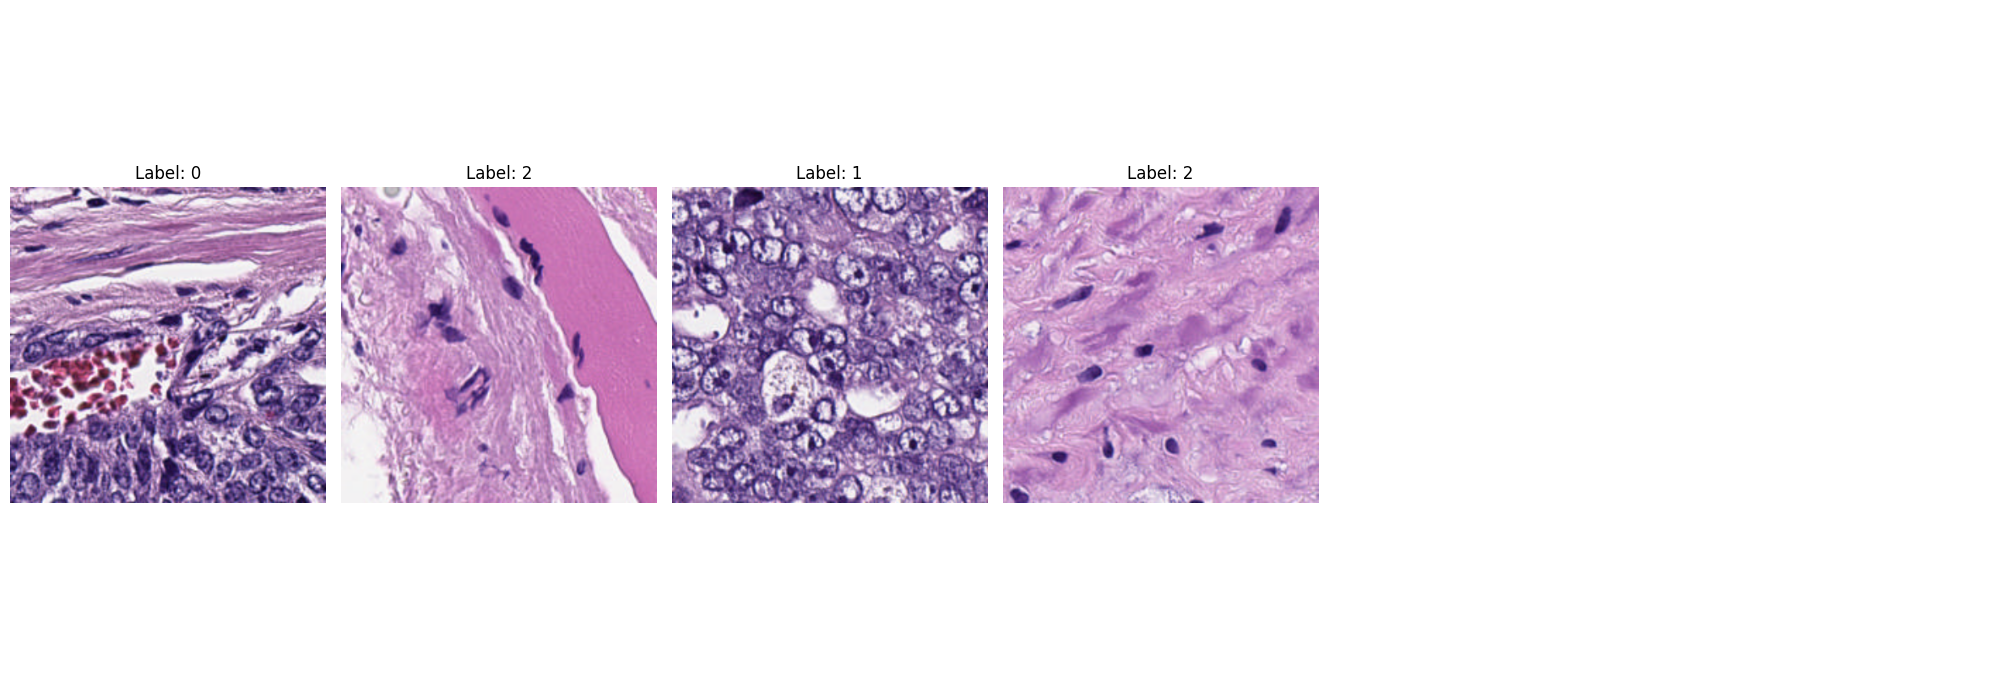

In [14]:
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image.
    Args:
        tensor (torch.Tensor): Normalized image tensor (C, H, W).
        mean (list or tuple): Mean values for each channel.
        std (list or tuple): Standard deviation values for each channel.
    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean).view(tensor.shape[0], 1, 1)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std).view(tensor.shape[0], 1, 1)

    return tensor * std + mean

def visualize_batch_denormalized(list_tensors, mean, std, titles=None, num_cols=4, figsize=None):
    """
    Visualizes a batch of DENORMALIZED image tensors in a grid.
    Args:
        list_tensors (torch.Tensor): List of image tensors (C, H, W), ASSUMED NORMALIZED.
        mean (list or tuple): Mean values used for normalization.
        std (list or tuple): Standard deviation values used for normalization.
        titles (list of str, optional): List of titles for each image.
        num_cols (int): Number of columns in the grid.
        figsize (tuple): Figure size (width, height).
    """
    batch_size = len(list_tensors)
    num_rows = math.ceil(batch_size / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (img_tensor, label) in enumerate(list_tensors):
        ax = axes[i]
        
        # Denormalize the image tensor
        denormalized_img_tensor = denormalize(img_tensor, mean, std)

        # Convert to numpy and handle channel order
        if denormalized_img_tensor.shape[0] == 1: # Grayscale
            img_np = denormalized_img_tensor.squeeze().cpu().numpy()
        else: # RGB
            img_np = denormalized_img_tensor.permute(1, 2, 0).cpu().numpy()
            
        # Clip values to [0, 1] in case of floating point inaccuracies
        img_np = np.clip(img_np, 0, 1)
            
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title("sample")
        if titles and i < len(titles):
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Label: {label}")
        
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch_denormalized(sample_subset, data_loader.dataset.normalize_mean, data_loader.dataset.normalize_std, num_cols=6, figsize=(20, 7))

In [15]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)
conditions = [{"y": [2]}]

input_zennit = sample.clone().detach()
input_zennit = input_zennit.unsqueeze(0)
input_zennit.requires_grad = True

cc = ChannelConcept()

attr = attribution(input_zennit, conditions, composite, record_layer=layer_names)
rel_c = cc.attribute(attr.relevances['features.8.0'], abs_norm=True)

In [16]:
rel_values, concept_ids = torch.topk(rel_c[0], 20)
concept_ids, rel_values*100

(tensor([ 711, 1204,   93,  627,  979,  755,  177,  946,  557,  569, 1195,  858,
          414,  356, 1348,  501,  572,  428,  866,  857]),
 tensor([1.0247, 0.8684, 0.6936, 0.5905, 0.5753, 0.5514, 0.5210, 0.5156, 0.5123,
         0.4515, 0.4515, 0.4342, 0.4168, 0.4168, 0.4146, 0.4038, 0.3951, 0.3908,
         0.3647, 0.3647]))

In [17]:
conditions = [{'features.8.0': [id], 'y': [3]} for id in concept_ids]
heatmap, _, _, _ = attribution(input_zennit, conditions, composite)

In [18]:
heatmap

tensor([[[4.8139e-06, 6.2234e-06, 1.4096e-06,  ..., 1.4075e-05,
          5.9377e-06, 5.9377e-06],
         [6.3978e-06, 8.8433e-06, 2.4456e-06,  ..., 2.0094e-05,
          8.3201e-06, 8.3201e-06],
         [1.5839e-06, 2.6199e-06, 1.0360e-06,  ..., 6.0193e-06,
          2.3824e-06, 2.3824e-06],
         ...,
         [1.2028e-05, 2.4097e-05, 1.2068e-05,  ..., 5.3484e-06,
          3.9504e-06, 3.9504e-06],
         [6.7613e-06, 1.3944e-05, 7.1827e-06,  ..., 3.1223e-06,
          2.1622e-06, 2.1622e-06],
         [6.7613e-06, 1.3944e-05, 7.1827e-06,  ..., 3.1223e-06,
          2.1622e-06, 2.1622e-06]],

        [[1.5170e-05, 1.9456e-05, 4.2862e-06,  ..., 4.5881e-05,
          1.9752e-05, 1.9752e-05],
         [2.0375e-05, 2.7730e-05, 7.3543e-06,  ..., 6.5187e-05,
          2.7206e-05, 2.7206e-05],
         [5.2056e-06, 8.2736e-06, 3.0680e-06,  ..., 1.9306e-05,
          7.4546e-06, 7.4546e-06],
         ...,
         [4.3372e-05, 8.3690e-05, 4.0319e-05,  ..., 1.4456e-05,
          1.109

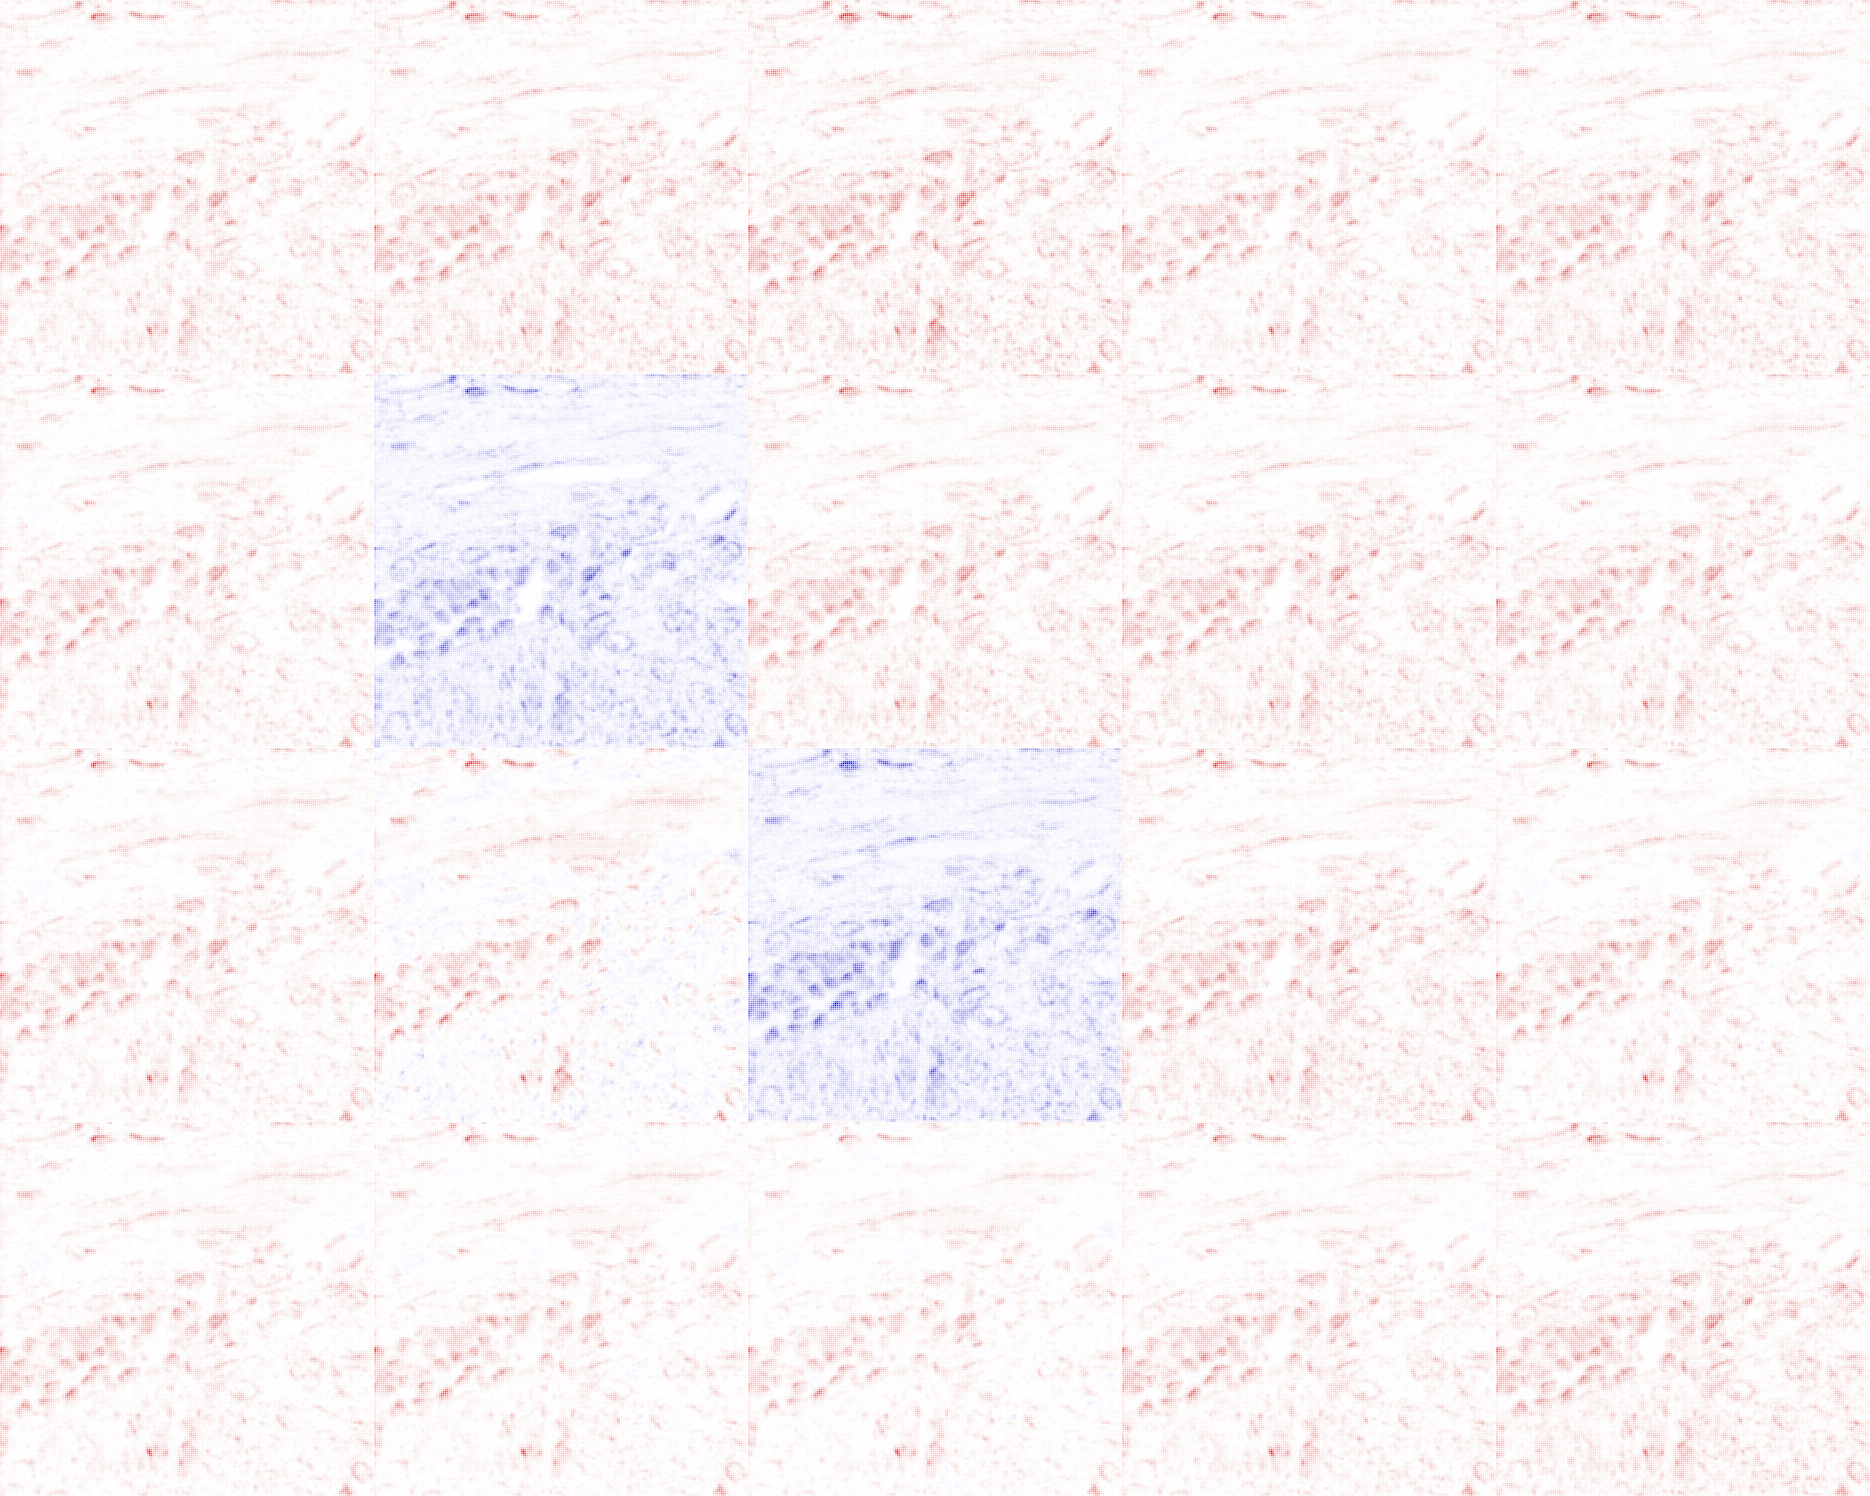

In [19]:
imgify(heatmap, symmetric=True, grid=(4,5))

In [20]:
heatmap[0] - heatmap[1]

tensor([[-1.0356e-05, -1.3233e-05, -2.8767e-06,  ..., -3.1806e-05,
         -1.3814e-05, -1.3814e-05],
        [-1.3978e-05, -1.8886e-05, -4.9087e-06,  ..., -4.5093e-05,
         -1.8886e-05, -1.8886e-05],
        [-3.6216e-06, -5.6537e-06, -2.0320e-06,  ..., -1.3286e-05,
         -5.0723e-06, -5.0723e-06],
        ...,
        [-3.1344e-05, -5.9594e-05, -2.8250e-05,  ..., -9.1073e-06,
         -7.1419e-06, -7.1419e-06],
        [-1.6408e-05, -3.2836e-05, -1.6428e-05,  ..., -5.3012e-06,
         -4.0138e-06, -4.0138e-06],
        [-1.6408e-05, -3.2836e-05, -1.6428e-05,  ..., -5.3012e-06,
         -4.0138e-06, -4.0138e-06]])

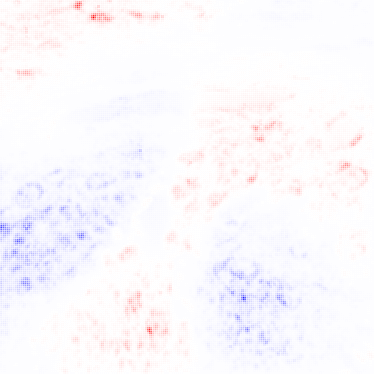

In [21]:
conditions = [{'features.8.0': [20], 'y': [3]}]
heatmap_rand, _, _, _ = attribution(input_zennit, conditions, composite)
imgify(heatmap_rand, symmetric=True)

In [22]:
def find_ess_heatmaps(heatmaps, tol=0.1):
	unique = []
	neg_tol = 1 - tol

	for hm in heatmaps:
		found = False
		for elem in unique:
			pearson = scipy.stats.pearsonr(elem.flatten(), hm.flatten())[0]

			if np.abs(pearson) > neg_tol:
				found = True
				break

		if not found:
			unique.append(hm)

	final_heatmap = torch.stack(unique)
	return final_heatmap

unique_heatmap = find_ess_heatmaps(heatmap)

In [23]:
unique_heatmap.shape

torch.Size([2, 374, 374])

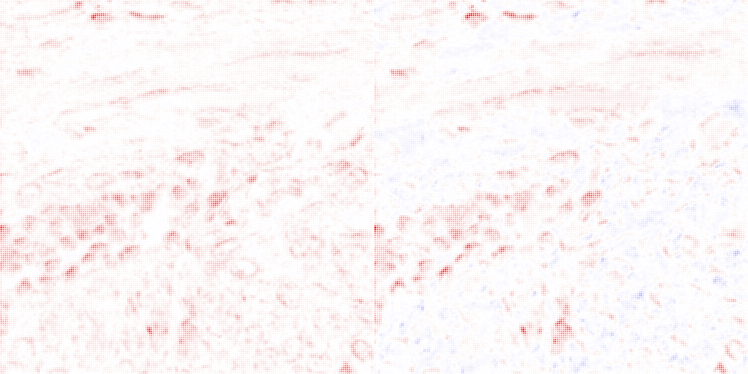

In [24]:
imgify(unique_heatmap, symmetric=True, grid=(1,2))

In [42]:
def plot_relevances(*relevances):
	fig, ax = plt.subplots(figsize=(10, 5))
	bar_width = 0.6
	bar_gap = 0.2
	colors = plt.cm.tab10.colors  # Use a colormap for up to 10 relevances
	top_n = 10

	for idx, rel in enumerate(relevances):
		rel_np = np.abs(rel[0].cpu().numpy())
		sorted_indices = np.argsort(-rel_np)
		selected_indices = sorted_indices[:top_n]
		selected_values = rel_np[selected_indices]
		indices = np.arange(len(selected_indices))
		ax.bar(indices + idx * (bar_width + bar_gap), selected_values, width=bar_width, 
			   label=f'Relevance {idx+1}', color=colors[idx % len(colors)])
		ax.set_xticks(indices + (len(relevances)-1)/2 * (bar_width + bar_gap))
		ax.set_xticklabels(selected_indices)
	
	ax.set_xlabel('Channel Index')
	ax.set_ylabel('Relevance Value')
	ax.legend()
	plt.show()

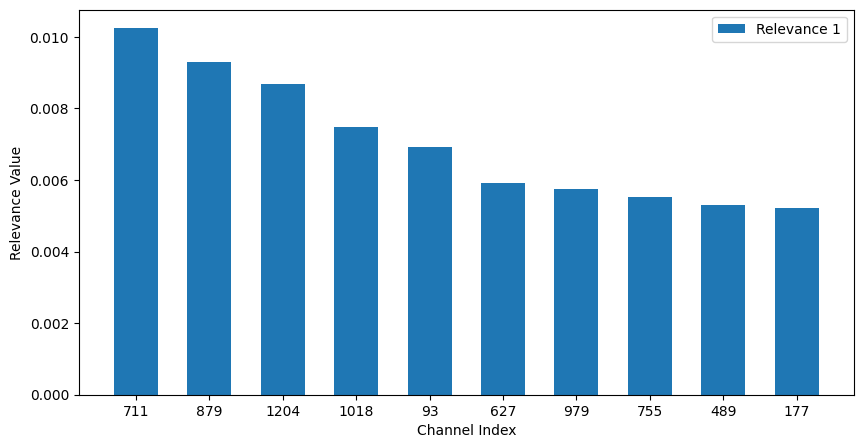

In [43]:
plot_relevances(rel_c)

# 2. xMI

In [27]:
json_xmi = read_json('config_prostate_xmi.json')
model_chkpt_xmi = 'saved/models/xMI-Efficient/0603_111814/model_best.pth'

In [28]:
config_xmi = ConfigParser(json_xmi, resume=model_chkpt_xmi)
checkpoint_xmi = torch.load(config_xmi.resume, weights_only = False)
state_dict_xmi = checkpoint_xmi['state_dict']

In [29]:
model_xmi = config_xmi.init_obj('arch', module_arch)

model_xmi.load_state_dict(state_dict_xmi)
model_xmi.eval()

xMIEfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActi

In [30]:
get_layer_names(model_xmi, [torch.nn.Conv2d, torch.nn.Linear])

['features.0.0',
 'features.1.0.block.0.0',
 'features.1.0.block.1.fc1',
 'features.1.0.block.1.fc2',
 'features.1.0.block.2.0',
 'features.1.1.block.0.0',
 'features.1.1.block.1.fc1',
 'features.1.1.block.1.fc2',
 'features.1.1.block.2.0',
 'features.2.0.block.0.0',
 'features.2.0.block.1.0',
 'features.2.0.block.2.fc1',
 'features.2.0.block.2.fc2',
 'features.2.0.block.3.0',
 'features.2.1.block.0.0',
 'features.2.1.block.1.0',
 'features.2.1.block.2.fc1',
 'features.2.1.block.2.fc2',
 'features.2.1.block.3.0',
 'features.2.2.block.0.0',
 'features.2.2.block.1.0',
 'features.2.2.block.2.fc1',
 'features.2.2.block.2.fc2',
 'features.2.2.block.3.0',
 'features.3.0.block.0.0',
 'features.3.0.block.1.0',
 'features.3.0.block.2.fc1',
 'features.3.0.block.2.fc2',
 'features.3.0.block.3.0',
 'features.3.1.block.0.0',
 'features.3.1.block.1.0',
 'features.3.1.block.2.fc1',
 'features.3.1.block.2.fc2',
 'features.3.1.block.3.0',
 'features.3.2.block.0.0',
 'features.3.2.block.1.0',
 'features

In [31]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
layer_names_xmi = get_layer_names(model_xmi, [torch.nn.Conv2d, torch.nn.Linear])
attribution_xmi = CondAttribution(model_xmi, no_param_grad=True)
conditions = [{"y": [2]}]

input_zennit = sample.clone().detach()
input_zennit = input_zennit.unsqueeze(0)
input_zennit.requires_grad = True

attr = attribution_xmi(input_zennit, conditions, composite, record_layer=layer_names_xmi)
rel_c_xmi = cc.attribute(attr.relevances['mi_layer.1'], abs_norm=True)
rel_values_xmi, concept_ids_xmi = torch.topk(rel_c_xmi[0], 20)
concept_ids_xmi, rel_values_xmi*100

(tensor([16, 29, 34, 42, 48,  1, 13, 35,  4,  0, 43, 12, 10, 27, 31, 40, 17, 49,
         14, 25]),
 tensor([8.1966, 7.2207, 6.6038, 4.7605, 3.2630, 3.1454, 2.9214, 1.7782, 1.7234,
         1.4725, 1.1558, 0.7471, 0.7447, 0.7378, 0.5710, 0.4261, 0.4106, 0.4094,
         0.3155, 0.2785]))

In [32]:
generate_results(model_xmi)

Model prediction 10. GT-Label: 0
Model prediction 2. GT-Label: 2
Model prediction 1. GT-Label: 1
Model prediction 2. GT-Label: 2


In [33]:
conditions = [{'mi_layer.1': [id], 'y': [3]} for id in concept_ids_xmi]
heatmap_xmi, _, _, _ = attribution_xmi(input_zennit, conditions, composite)

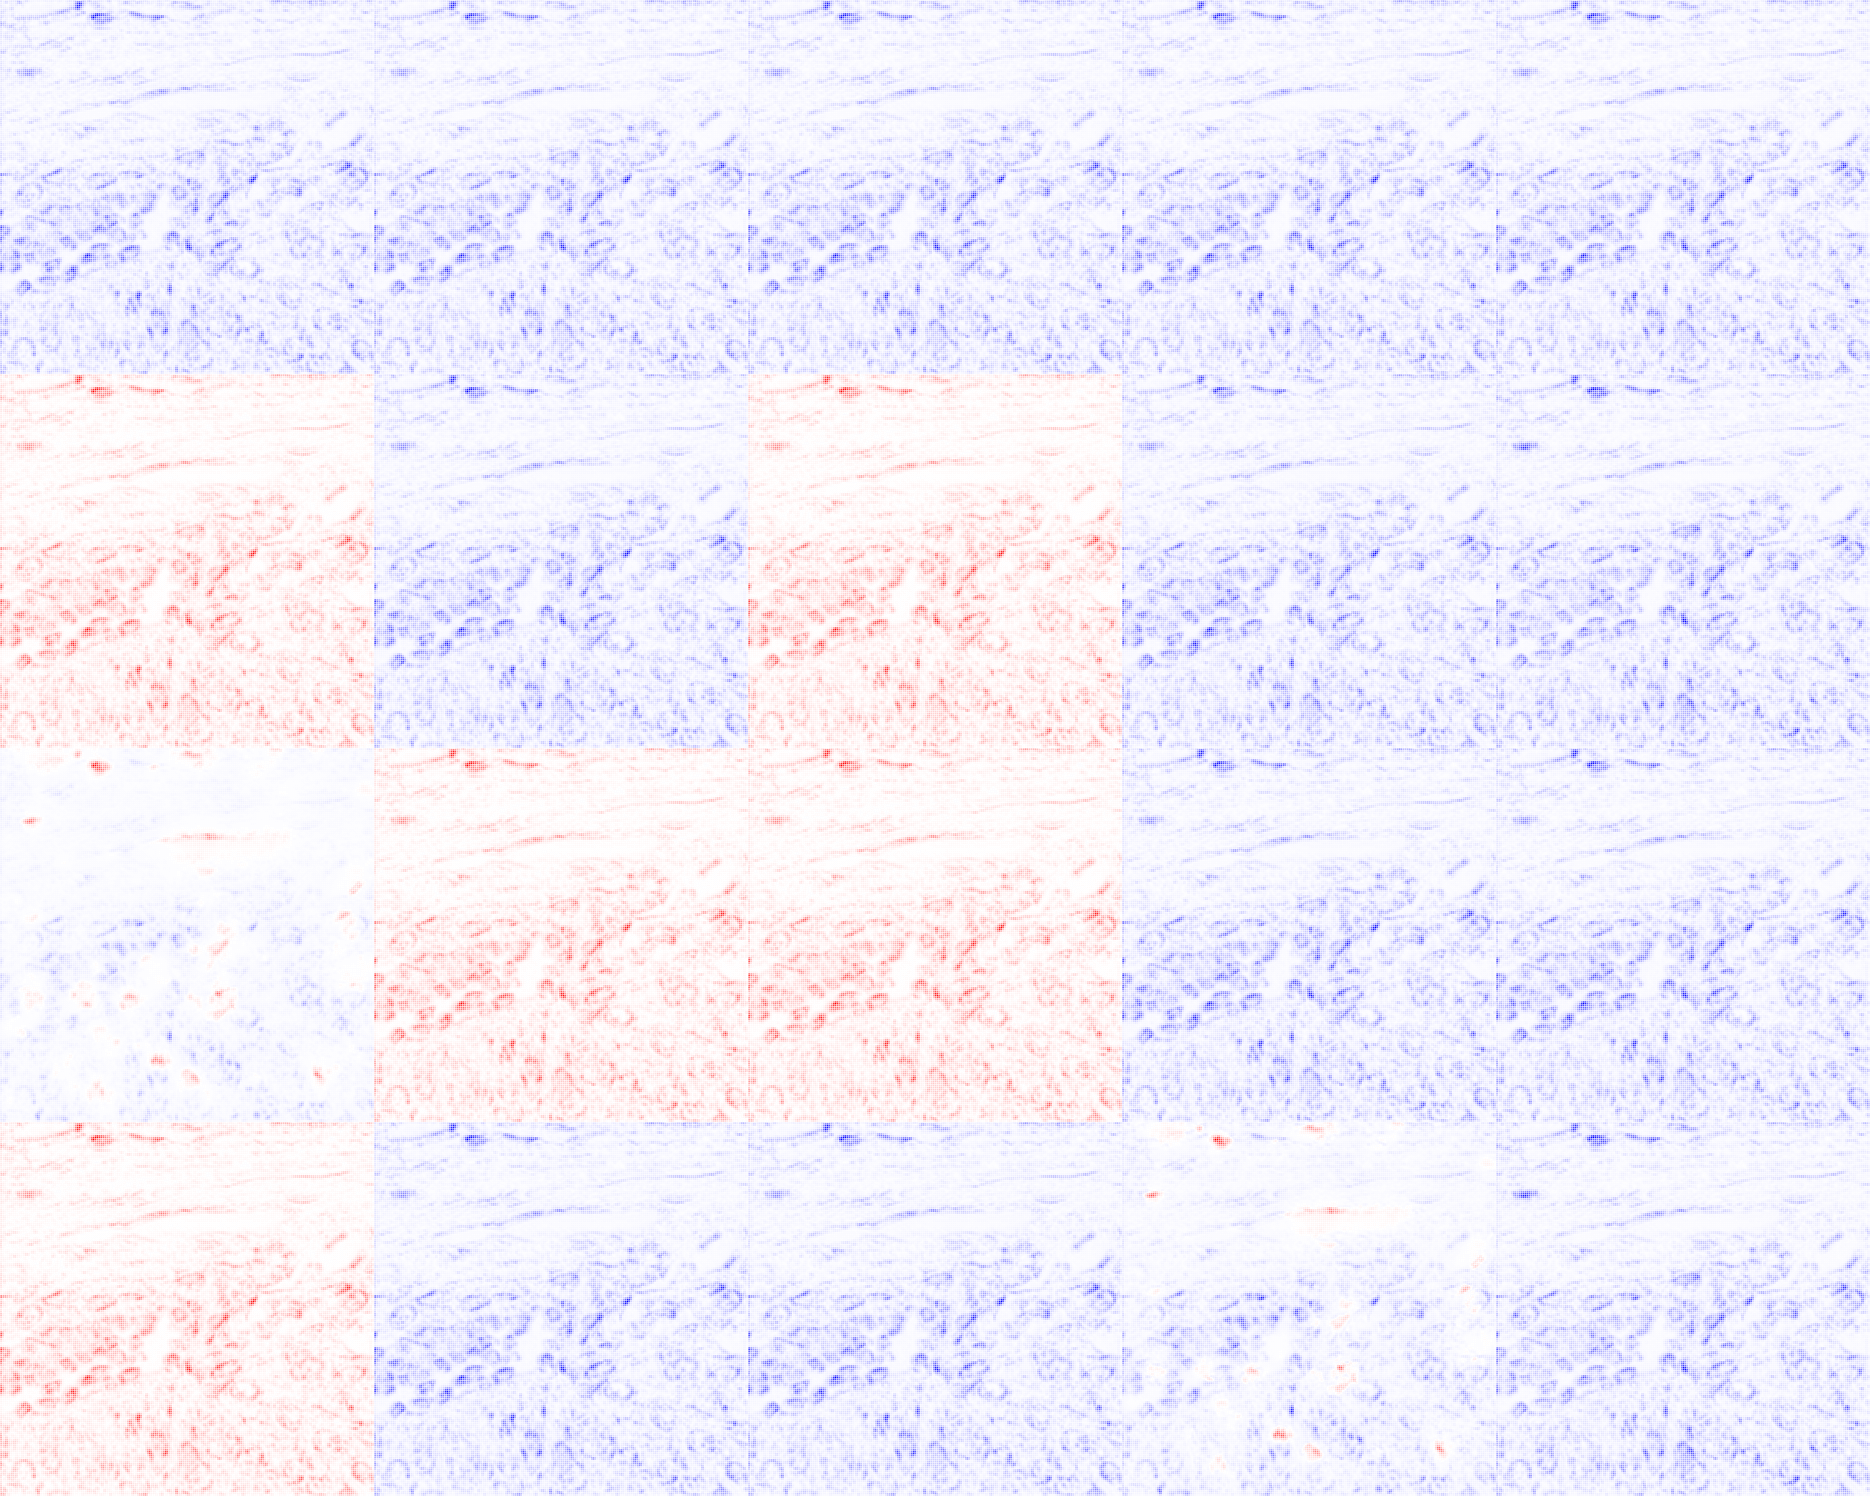

In [34]:
imgify(heatmap_xmi, symmetric=True, grid=(4,5))

In [35]:
model_xmi.train()
model_xmi(sample.unsqueeze(0))

tensor([[-2.9294, -3.1143, -3.2052, -3.4132, -1.9693, -2.6907, -2.0886, -2.7731,
         -2.0309, -3.3854, -1.9840, -3.2837, -3.0979, -3.0011]])

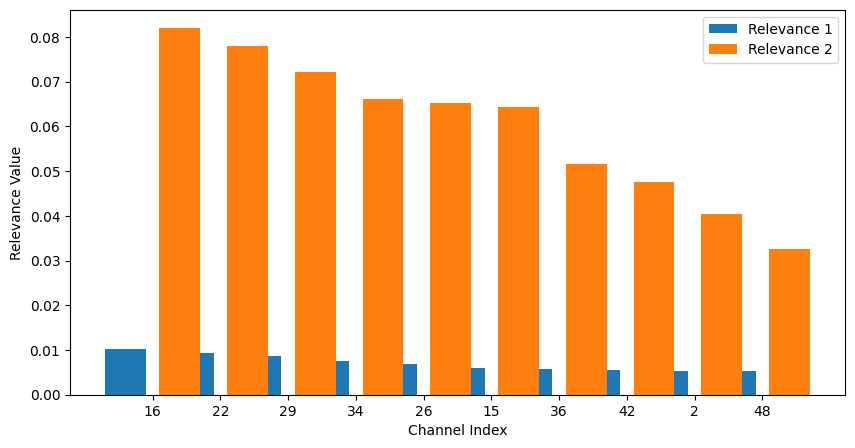

In [44]:
plot_relevances(rel_c, rel_c_xmi)

# 3. Reentrenamiento con pesos congelados

In [36]:
json = read_json('config_prostate.json')
model_chkpt = 'saved/models/fCRP-prostate/0602_001536/model_best.pth'

In [37]:
config = ConfigParser(json, resume=model_chkpt)

In [38]:
checkpoint = torch.load(config.resume, weights_only = False)
state_dict = checkpoint['state_dict']

In [39]:
model = config.init_obj('arch', module_arch)

model.load_state_dict(state_dict)
model.eval()

data_loader = config.init_obj('data_loader_test', module_data)
sample_subset = [data_loader.dataset[i] for i in {600, 700, 800, 1000, 1100, 20}]

IndexError: list index out of range

In [ ]:
sample_subset[0][0].shape

torch.Size([3, 374, 374])

In [ ]:
sample, idx = sample_subset[0]

In [ ]:
model(sample.unsqueeze(0)).argmax()

tensor(3)

In [ ]:
def generate_results(model):
	model.eval()
	for (input, label) in sample_subset:
		output = model(input.unsqueeze(0))
		pred_class = output.argmax()
		print(f"Model prediction {pred_class}. GT-Label: {label}")
	model.train()

generate_results(model)

Model prediction 3. GT-Label: 3
Model prediction 6. GT-Label: 6
Model prediction 10. GT-Label: 10
Model prediction 0. GT-Label: 0
Model prediction 3. GT-Label: 3
Model prediction 3. GT-Label: 3


In [ ]:
from crp.helper import get_layer_names

conditions = [{"y": 46}]
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

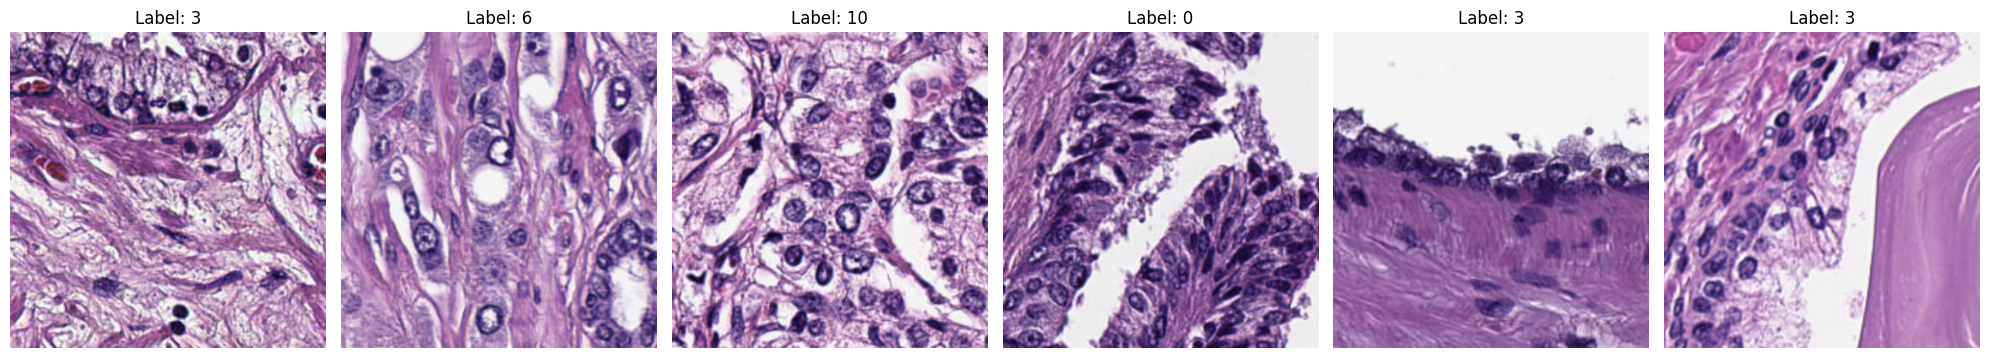

In [ ]:
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image.
    Args:
        tensor (torch.Tensor): Normalized image tensor (C, H, W).
        mean (list or tuple): Mean values for each channel.
        std (list or tuple): Standard deviation values for each channel.
    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean).view(tensor.shape[0], 1, 1)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std).view(tensor.shape[0], 1, 1)

    return tensor * std + mean

def visualize_batch_denormalized(list_tensors, mean, std, titles=None, num_cols=4, figsize=None):
    """
    Visualizes a batch of DENORMALIZED image tensors in a grid.
    Args:
        list_tensors (torch.Tensor): List of image tensors (C, H, W), ASSUMED NORMALIZED.
        mean (list or tuple): Mean values used for normalization.
        std (list or tuple): Standard deviation values used for normalization.
        titles (list of str, optional): List of titles for each image.
        num_cols (int): Number of columns in the grid.
        figsize (tuple): Figure size (width, height).
    """
    batch_size = len(list_tensors)
    num_rows = math.ceil(batch_size / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (img_tensor, label) in enumerate(list_tensors):
        ax = axes[i]
        
        # Denormalize the image tensor
        denormalized_img_tensor = denormalize(img_tensor, mean, std)

        # Convert to numpy and handle channel order
        if denormalized_img_tensor.shape[0] == 1: # Grayscale
            img_np = denormalized_img_tensor.squeeze().cpu().numpy()
        else: # RGB
            img_np = denormalized_img_tensor.permute(1, 2, 0).cpu().numpy()
            
        # Clip values to [0, 1] in case of floating point inaccuracies
        img_np = np.clip(img_np, 0, 1)
            
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title("sample")
        if titles and i < len(titles):
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Label: {label}")
        
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch_denormalized(sample_subset, data_loader.dataset.normalize_mean, data_loader.dataset.normalize_std, num_cols=6, figsize=(20, 7))

In [ ]:
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)
conditions = [{"y": [2]}]

input_zennit = sample.clone().detach()
input_zennit = input_zennit.unsqueeze(0)
input_zennit.requires_grad = True

cc = ChannelConcept()

attr = attribution(input_zennit, conditions, composite, record_layer=layer_names)
rel_c = cc.attribute(attr.relevances['model.features.8.0'], abs_norm=True)

In [ ]:
rel_values, concept_ids = torch.topk(rel_c[0], 20)
concept_ids, rel_values*100

(tensor([1266,  478,  259,   88,  911, 1097,  517,  532,  684, 1199, 1219,  833,
          715,  173, 1321,   74,  218,  916, 1111,  436]),
 tensor([0.9713, 0.9179, 0.8592, 0.7898, 0.7445, 0.7151, 0.5764, 0.5497, 0.5390,
         0.4910, 0.4896, 0.4803, 0.4483, 0.4430, 0.4376, 0.4209, 0.4163, 0.3842,
         0.3762, 0.3736]))

In [ ]:
conditions = [{'model.features.8.0': [id], 'y': [3]} for id in concept_ids]
heatmap, _, _, _ = attribution(input_zennit, conditions, composite)

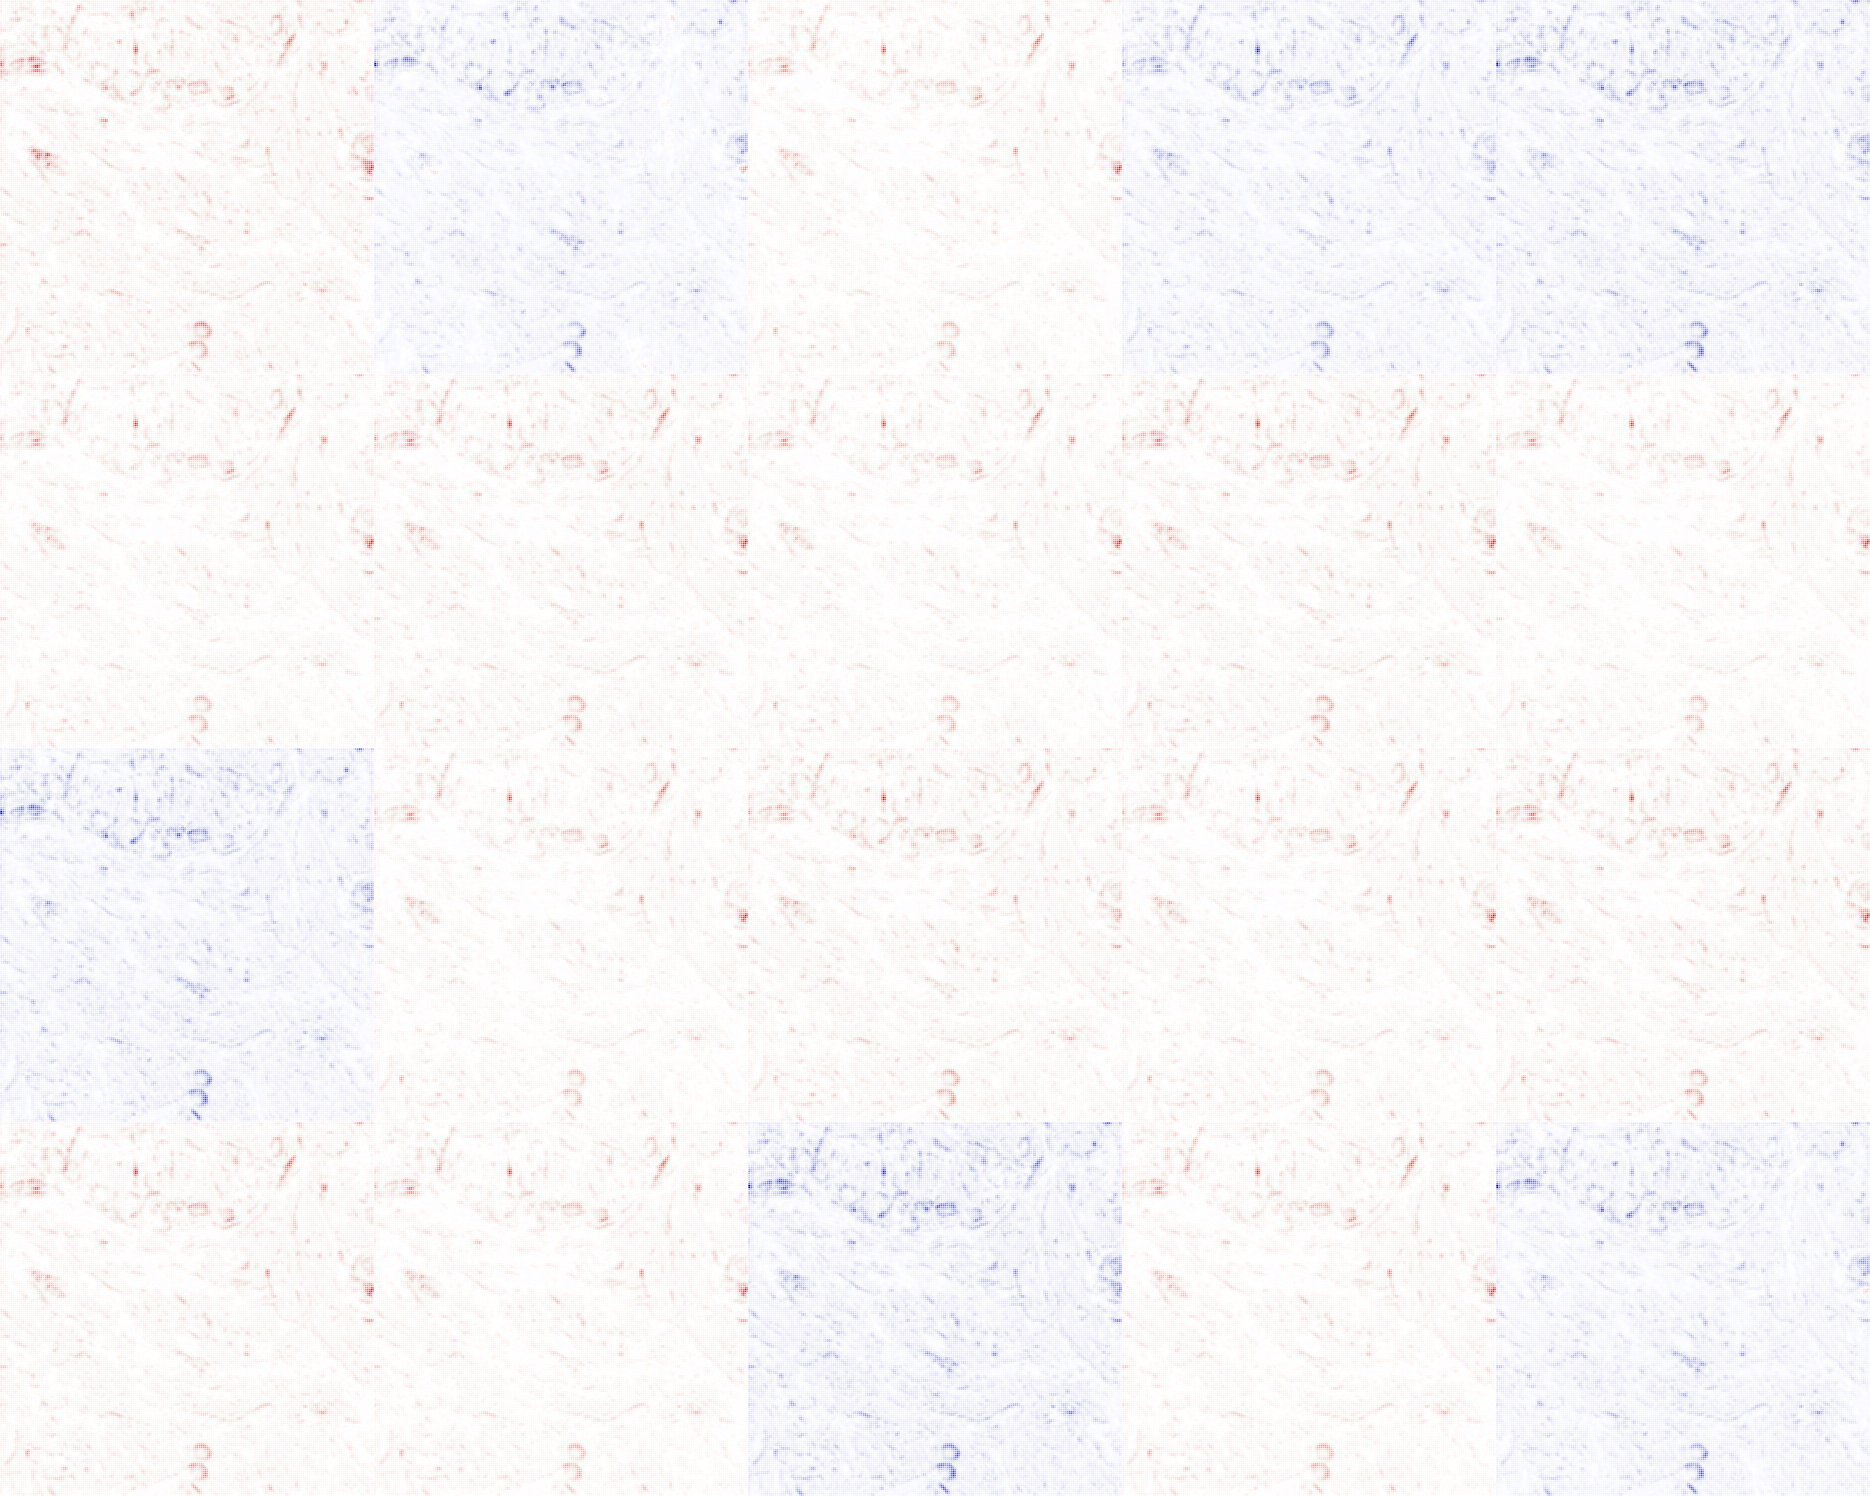

In [ ]:
imgify(heatmap, symmetric=True, grid=(4,5))

In [ ]:
heatmap[0] - heatmap[1]

tensor([[ 5.9989,  7.5138,  1.5149,  ..., 19.3094, 13.0773, 13.0773],
        [ 8.6851, 11.6007,  2.9156,  ..., 28.0524, 19.5232, 19.5232],
        [ 2.6862,  4.0869,  1.4007,  ...,  8.7431,  6.4459,  6.4459],
        ...,
        [ 8.1108,  9.9349,  1.8240,  ...,  6.4914,  3.3951,  3.3951],
        [ 3.6506,  4.5444,  0.8938,  ...,  3.8644,  1.9154,  1.9154],
        [ 3.6506,  4.5444,  0.8938,  ...,  3.8644,  1.9154,  1.9154]])

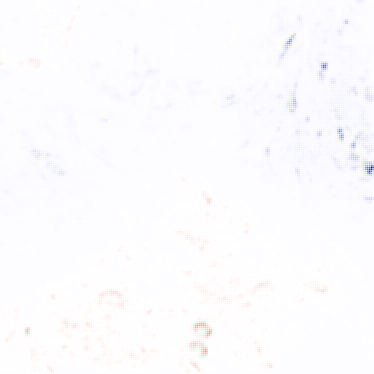

In [ ]:
conditions = [{'model.features.8.0': [20], 'y': [3]}]
heatmap_rand, _, _, _ = attribution(input_zennit, conditions, composite)
imgify(heatmap_rand, symmetric=True)

In [ ]:
def find_ess_heatmaps(heatmaps, tol=0.1):
	unique = []
	neg_tol = 1 - tol

	for hm in heatmaps:
		found = False
		for elem in unique:
			pearson = scipy.stats.pearsonr(elem.flatten(), hm.flatten())[0]

			if np.abs(pearson) > neg_tol:
				found = True
				break

		if not found:
			unique.append(hm)

	final_heatmap = torch.stack(unique)
	return final_heatmap

unique_heatmap = find_ess_heatmaps(heatmap)

In [ ]:
unique_heatmap.shape

torch.Size([2, 374, 374])

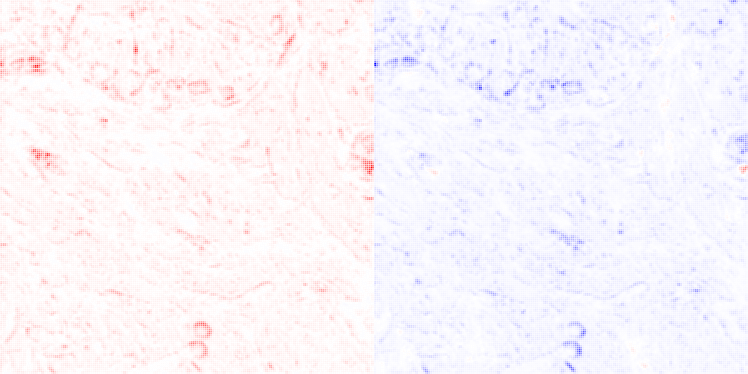

In [ ]:
imgify(unique_heatmap, symmetric=True, grid=(1,2))

In [ ]:
input_zennit.shape

torch.Size([1, 3, 374, 374])

In [ ]:
torch.stack([
	torch.Tensor([1,2,3]),
torch.Tensor([1,2,3]),
])

tensor([[1., 2., 3.],
        [1., 2., 3.]])